In [1]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string

importing qubicpack without pystudio


In [2]:
rc('figure',figsize=(10,7))

## Dataset

Get the directories corresponding to the day we consider:

In [3]:
day = '2019-02-22'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.sort(glob.glob(data_dir+'/*'))
print dirs
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
print labels

['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.11.38__Scan1'
 '/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2']
['Scan1', 'Scan2']


## Select one directory to start with

In [4]:
thedir = dirs[1]

## Reading Azimuth data

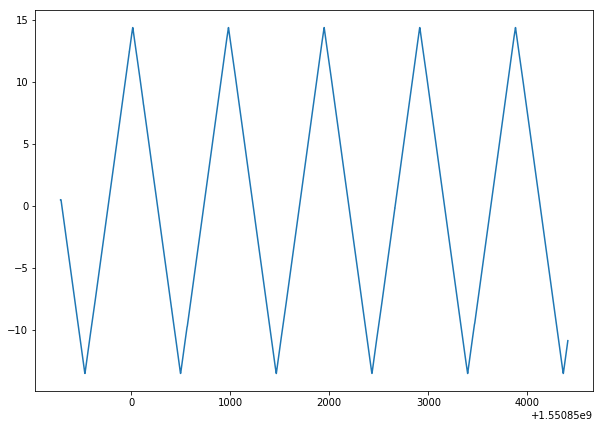

In [5]:
t_az, azinit = ft.read_hkintern(thedir,thefieldname='Platform-Azimut')
az = (azinit-2.**15)/(2.**16)*360
plot(t_az, az)

## Reading data for a given asic and pixel

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

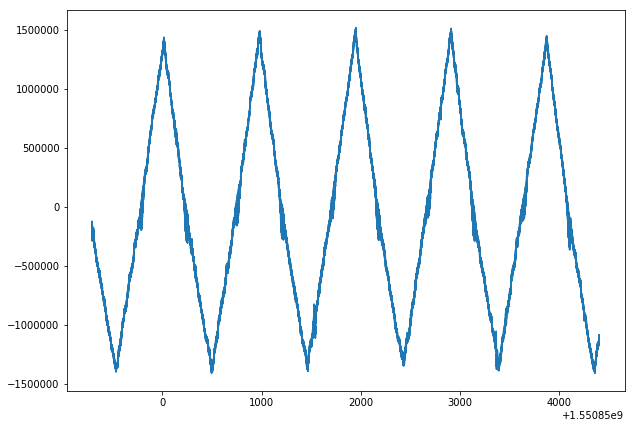

In [6]:
AsicNum = 1
TESNum = 96

a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)
data = a.timeline(TES=TESNum)

#t_data = a.timeline_timeaxis(axistype='pps')
#t_data = a.timeline_timeaxis(axistype='index')
t_data = a.timeline_timeaxis(axistype='index')
pps=a.pps()
gps=a.gps()
t0 = np.min(a.pps2date(pps,gps))
t_data = t_data + t0

plot(t_data, data)

## Reading CalSrc Data

['/qubic/Data/Calib-TD/calsource/calsource_20190222T150113.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190222T161710.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190222T164144.dat']


Text(0.5,0,'Time (s)')

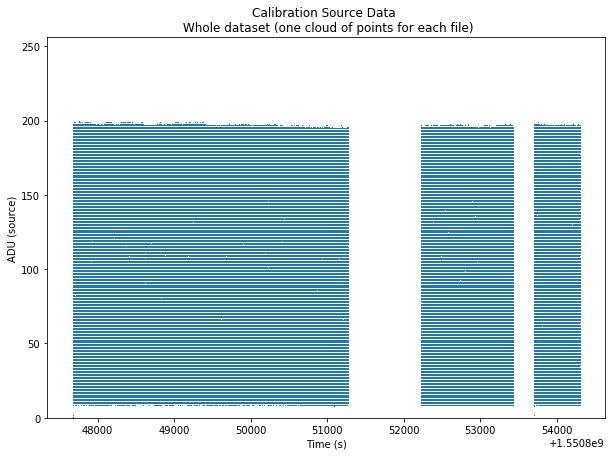

In [7]:
##### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc.sort()
print fcalsrc

ttsrc_i = []
ddsrc_i = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    ttsrc_i.append(thett+3600)
    ddsrc_i.append(thedd)
    
t_src = np.concatenate(ttsrc_i)
data_src = np.concatenate(ddsrc_i)

############### Plot this data
plot(t_src,data_src,',')
ylim(0,256)
title('Calibration Source Data \n Whole dataset (one cloud of points for each file)')
ylabel('ADU (source)')
xlabel('Time (s)')


## Display Data along with Azimuth and CalSrc, synchronize them

We first check for synchronization of the three datasets

(-3, 3)

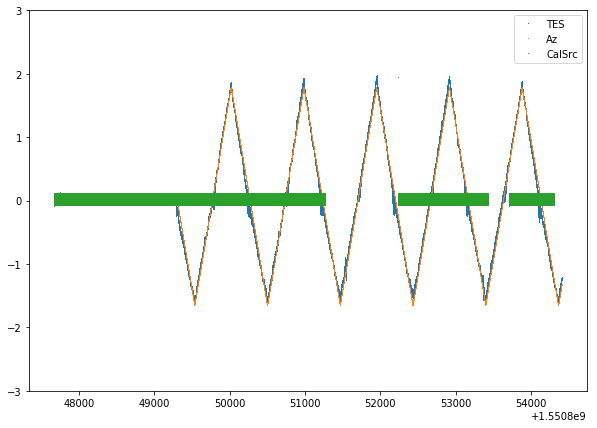

In [8]:
plot(t_data, (data-np.mean(data))/np.std(data),',',label='TES')
plot(t_az, (az-np.mean(az))/np.std(az),',',label='Az')
plot(t_src, (data_src-np.mean(data_src))/np.std(data_src)/5,',',label='CalSrc')
legend()
ylim(-3,3)

We will focus on the first part where there is common data... we loose the rest for now but may get it back if we use the model of the source signal instead of the source itself.

In [9]:
tmin = np.max([np.min(t_data), np.min(t_az), np.min(ttsrc_i[0])])
tmax = np.min([np.max(t_data), np.max(t_az), np.max(ttsrc_i[0])])

okdata = (t_data >= tmin) & (t_data <= tmax)
t_data = t_data[okdata]
data = data[okdata]

okaz = (t_az >= tmin) & (t_az <= tmax)
t_az = t_az[okaz]
az = az[okaz]

oksrc = (t_src >= tmin) & (t_src <= tmax)
t_src = t_src[oksrc]
data_src = data_src[oksrc]

(-3, 3)

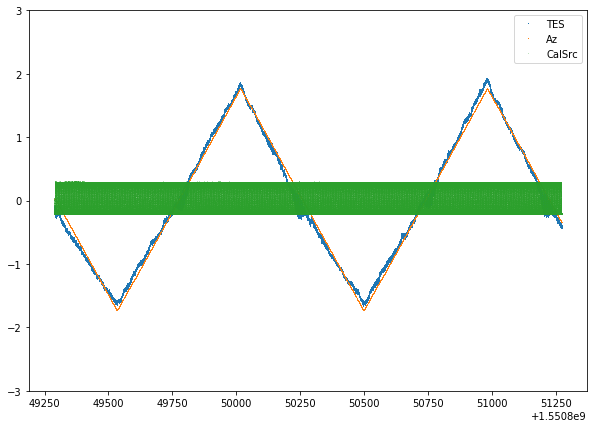

In [10]:
plot(t_data, (data-np.mean(data))/np.std(data),',',label='TES')
plot(t_az, (az-np.mean(az))/np.std(az),',',label='Az')
plot(t_src, (data_src-np.mean(data_src))/np.std(data_src)/5,',',label='CalSrc', alpha=0.3)
legend()
ylim(-3,3)

# Beam Measurement

## First Method: RMS over a period
This method is really a poorman's approach to demodulation but it has the advantage of being fast: we measure the RMS of the data for each epriod of the source signal and knowing the azimuth for each of these period we can plot the amplitude of the source as a function of azimuth. It has the advantage of naturally getting rid of the varying offset of the data. This method does not use the CalSrc signal, only its modulation frequency (0.333 Hz)

We first need to measure the epriod of the signal:

(1000000.0, 1000000000000.0)

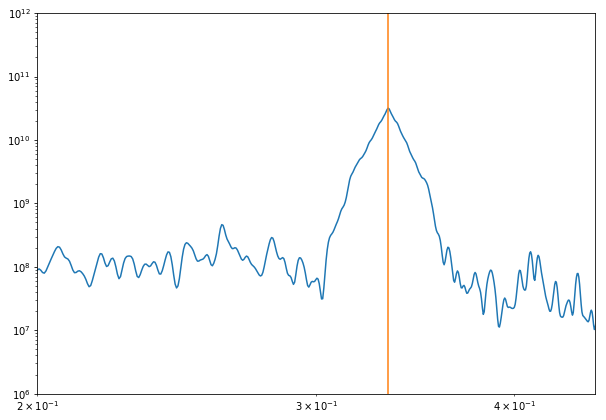

In [11]:
FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), window=mlab.window_hanning)
plot(freq_f, f.gaussian_filter1d(spectrum_f,2))
yscale('log')
xscale('log')
xlim(0.2,0.45)
freq_mod = 0.333
plot([freq_mod, freq_mod], [1e6, 1e12])
ylim(1e6, 1e12)

Now we go for the RMS per period analysis

In [12]:
### Interpolate azimuth on the 
new_az = np.interp(t_data, t_az, az)

### Period of the modulation in sec
ppp = 1./freq_mod

def return_rms_period(period, time, azimuth, data):
    ### we label each data sample with a period
    period_index = ((time-time[0])/period).astype(int)
    ### We loop on periods to measure their respective amplitude and azimuth
    allperiods = np.unique(period_index)
    tper = np.zeros(len(allperiods))
    azper = np.zeros(len(allperiods))
    ampdata = np.zeros(len(allperiods))
    err_ampdata = np.zeros(len(allperiods))
    for i in xrange(len(allperiods)):
        ok = (period_index == allperiods[i])
        azper[i] = np.mean(azimuth[ok])
        tper[i] = np.mean(time[ok])
        ampdata[i] = np.std(data[ok])
        err_ampdata[i] = np.std(data[ok])/np.sqrt(2*ok.sum())
    return tper, azper, ampdata, err_ampdata

tper, azper, ampdata, err_ampdata = return_rms_period(ppp, t_data, new_az, data)

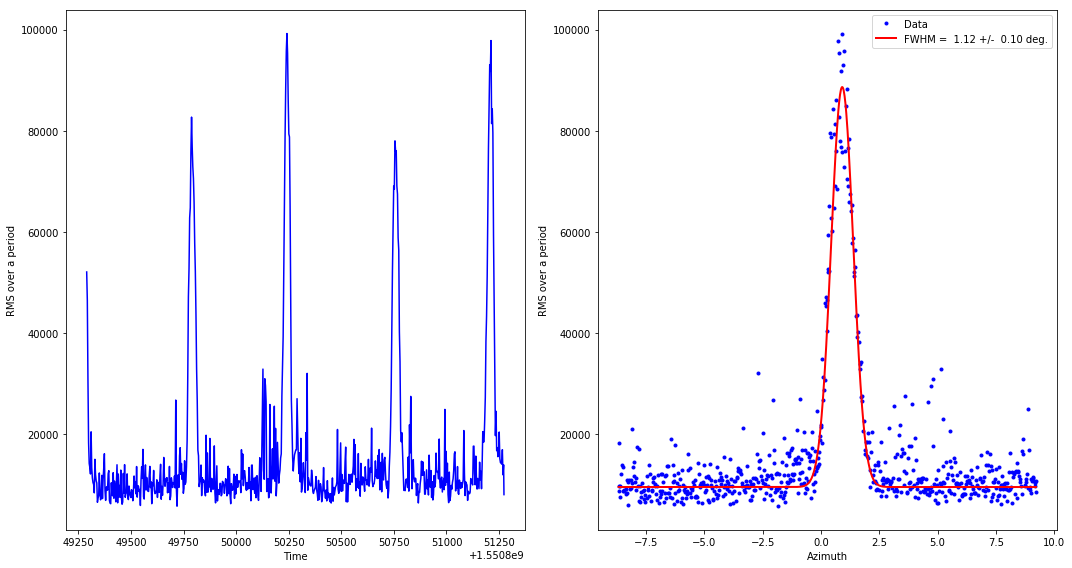

In [13]:
### Correct for cos(elevation) in order to get angles on the sky
elevation = 50.
angle = azper * np.cos(np.radians(elevation))

def gauss(x,par):
    return par[3]+par[2]*np.exp(-0.5 * (x-par[0])**2 / par[1]**2)

thecut = 3500000
okfit = (ampdata < thecut) & (err_ampdata > 0)

### Guess for the peak location
amprenorm = (ampdata-np.min(ampdata))
amprenorm = amprenorm / np.sum(amprenorm)
peak_guess = np.sum(azper * (amprenorm))

reload(ft)
guess = np.array([peak_guess, 1., np.max(ampdata)-np.min(ampdata), np.min(ampdata)])
res = ft.do_minuit(angle[okfit], ampdata[okfit], err_ampdata[okfit], guess, 
                   functname=gauss, verbose=False,nohesse=True)

xxx = np.linspace(np.min(angle), np.max(angle), 1000)

rc('figure',figsize=(15,8))
subplot(1,2,1)
plot(tper,ampdata,'b')
xlabel('Time')
ylabel('RMS over a period')
subplot(1,2,2)
plot(angle,ampdata,'b.', label='Data')
plot(xxx, gauss(xxx, res[1]),'r',lw=2, 
     label='FWHM = {0:5.2f} +/- {1:5.2f} deg.'.format(2.35*res[1][1], 2*35*res[2][1]))
plot()
xlabel('Azimuth')
ylabel('RMS over a period')
legend()
tight_layout()

We now can loop on TES to get the result for the whole array

In [14]:
allamps = np.zeros((256, len(angle)))
allres = np.zeros((256,4))
allerr = np.zeros((256,4))


for AsicNum in [1,2]:
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=AsicNum)
    for TESNum in np.arange(128)+1:
        print(TESNum)
        TESindex = (TESNum-1)+128*(AsicNum-1)
        thedata = a.timeline(TES=TESNum)[okdata]
        tper, azper, ampdata, err_ampdata = return_rms_period(ppp, t_data, new_az, thedata)
        thecut = 3500000
        okfit = (ampdata < thecut) & (err_ampdata > 0)
        ### Guess for the peak location
        amprenorm = (ampdata-np.min(ampdata))
        amprenorm = amprenorm / np.sum(amprenorm)
        peak_guess = np.sum(azper * (amprenorm))
        guess = np.array([peak_guess, 1., np.max(ampdata)-np.min(ampdata), np.min(ampdata)])
        res = ft.do_minuit(angle[okfit], ampdata[okfit], err_ampdata[okfit], guess, 
                       functname=gauss, verbose=False,nohesse=True, force_chi2_ndf=True)
        allamps[TESindex,:] = ampdata
        allres[TESindex,:] = res[1]
        allerr[TESindex,:] = res[2]
        

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = +nan
    c1 = +nan
    c2 = +nan
    c3 = +nan

  m.migrad()


29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


fibtools.py:246: RuntimeWarning: invalid value encountered in sqrt
  return m, np.array(parfit), np.array(errfit) * np.sqrt(correct), np.array(covariance) * correct, chi2(*parfit), ndf


105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic2-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic2-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fit

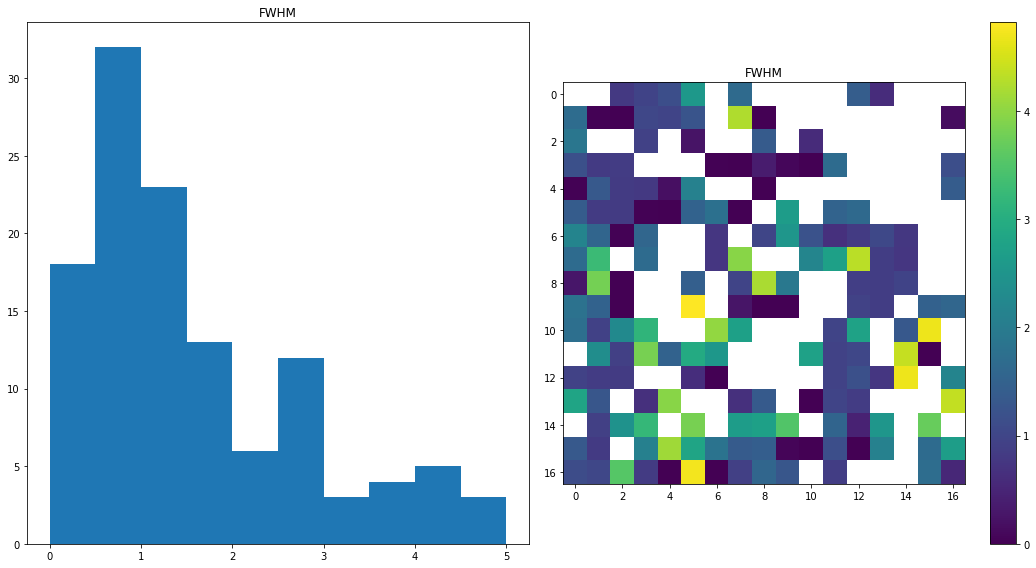

In [15]:
subplot(1,2,1)
hist(allres[:,1]*2.35, range=[0.,5], bins=10)
title('FWHM')
subplot(1,2,2)
vals = np.zeros(256)+np.nan
okfwhm = (np.abs(allres[:,1])*2.35 < 5) & ((allres[:,1]*2.35)<5)
vals[okfwhm] = np.abs(allres[okfwhm,1]*2.35)
imgfwhm = ft.image_asics(all1=vals)
imshow(imgfwhm)
title('FWHM')
colorbar()
tight_layout()

Text(0.5,1,'TES 6')

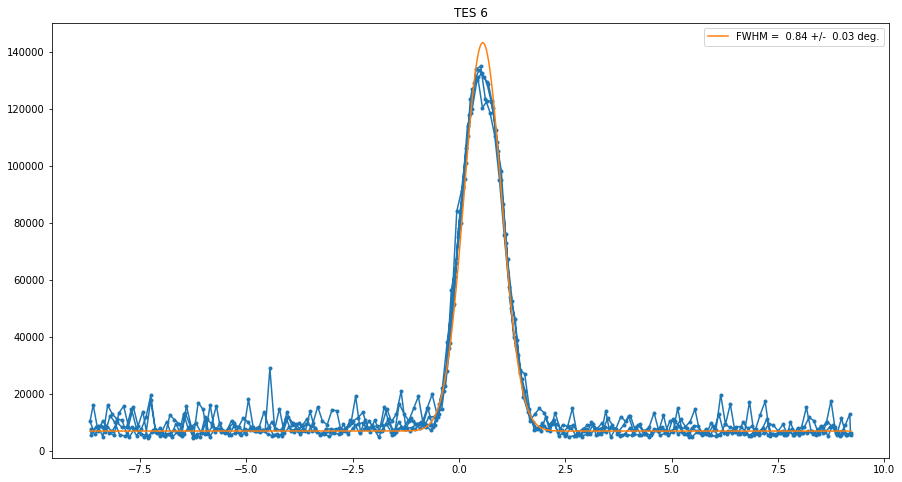

In [16]:
TESNum =6
plot(angle, allamps[TESNum-1,:],'.-')
plot(xxx, gauss(xxx, allres[TESNum-1,:]),
                label='FWHM = {0:5.2f} +/- {1:5.2f} deg.'.format(2.35*allres[TESNum,1], 2.35*allerr[TESNum,1]))
legend()
title('TES {}'.format(TESNum))

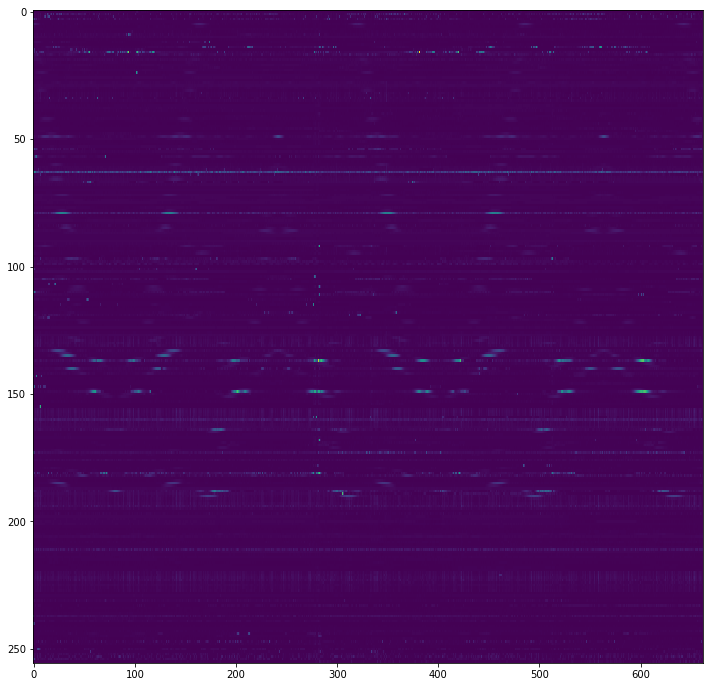

In [17]:
rc('figure',figsize=(12,12))
imshow(allamps,aspect='auto')

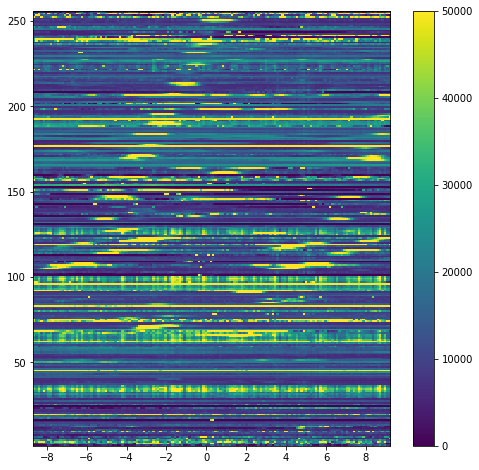

In [18]:
nbins=150
angfinalbins = min(angle)+(max(angle)-min(angle))*np.linspace(0,1,nbins+1)
angfinal = np.zeros(nbins)
ampfinal = np.zeros((256,nbins))
for ites in xrange(256):
    for i in xrange(nbins):
        ok = (angle >= angfinalbins[i]) & (angle < angfinalbins[i+1])
        angfinal[i] = 0.5 * (angfinalbins[i] + angfinalbins[i+1])
        ampfinal[ites, i] = np.mean(allamps[ites,ok])

rc('figure',figsize=(8,8))
imshow(ampfinal,aspect='auto', extent=[np.min(angle), np.max(angle),1,256], vmin=0, vmax=50000)
colorbar()

Text(0.5,1,'Azimuth Scan Amplitude')

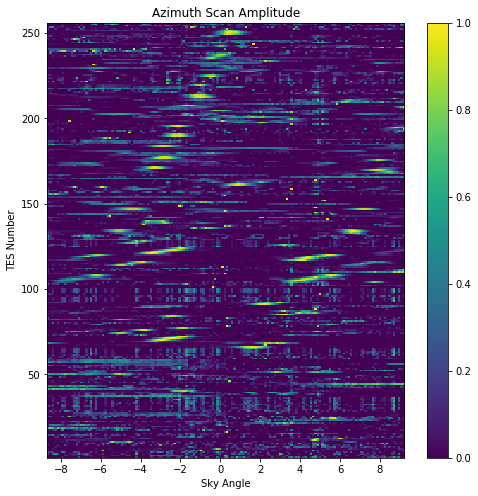

In [19]:
bla = ((ampfinal.T-np.median(ampfinal, axis=1))/(np.max(ampfinal,axis=1)-np.min(ampfinal,axis=1))).T
imshow(bla,aspect='auto', extent=[np.min(angle), np.max(angle),1,256],vmin=0,vmax=1)
colorbar()
xlabel('Sky Angle')
ylabel('TES Number')
title('Azimuth Scan Amplitude')

## Second Method: Demodulation

In [ ]:
FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), window=mlab.window_hanning)
plot(freq_f, f.gaussian_filter1d(spectrum_f,2))
yscale('log')
xscale('log')
xlim(0.2,0.45)
freq_mod = 0.333
plot([freq_mod, freq_mod], [1e6, 1e12])
ylim(1e6, 1e12)

In [20]:
def demodulate_and_rebin(time, data, t_az, az, t_src, src, lowcut, highcut, fmod, nbins, elevation):
    import scipy.signal as scsig
    
    ### Filter Data and Source Signal the same way
    FREQ_SAMPLING = 1./(time[1]-time[0])
    filt = scsig.butter(5, [lowcut / FREQ_SAMPLING, highcut / FREQ_SAMPLING], btype='bandpass', output='sos')
    # Filter Data and change its sign to be in the same as Src
    new_data = -scsig.sosfilt(filt, data)
    # Interpolate Src on data times and filter it
    new_src = scsig.sosfilt(filt, np.interp(time, t_src, src))

    # Make the product for demodulation
    product = new_data * new_src / np.sum(new_src**2)

    # Smooth it over a period
    ppp = 1./fmod
    size_period = int(FREQ_SAMPLING * ppp)+1
    filter_period = np.ones((size_period,))/size_period
    mov_av = np.convolve(product, filter_period, mode='same')
    
    # Rebin this demodulated data as a function of azimuth corrected for elevation
    ang_bin, amp_bin, dang, damp = ft.profile(np.interp(time, t_az, az)*np.cos(np.radians(elevation)), 
                                              mov_av, nbins=nbins,
                                              dispersion=True, plot=False, median=True)
    
    return ang_bin, amp_bin, dang, damp



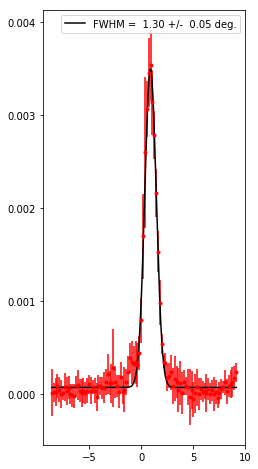

In [21]:
lowcut = 0.1
highcut = 15.
nbins = 100
freq_mod = 0.333
elevation = 50
ang_bin, amp_bin, dang, damp = demodulate_and_rebin(t_data, data, t_az, az, t_src, data_src, 
                                                    lowcut, highcut, freq_mod, nbins, elevation)

### Guess for the peak location
amp_bin_renorm = (amp_bin-np.min(amp_bin))
amp_bin_renorm = amp_bin_renorm / np.sum(amp_bin_renorm)
peak_guess = np.sum(ang_bin * (amp_bin_renorm))
amp_bin_renorm=0
guess = np.array([peak_guess, 1., np.max(amp_bin)-np.min(amp_bin), np.min(amp_bin)])
res = ft.do_minuit(ang_bin, amp_bin, damp, guess, 
               functname=gauss, verbose=False,nohesse=True, force_chi2_ndf=False)


subplot(1,2,2)
errorbar(ang_bin, amp_bin, yerr=damp,fmt='r.')
xxx = np.linspace(np.min(ang_bin), np.max(ang_bin), 1000)
plot(xxx, gauss(xxx, res[1]),'k-',
                label='FWHM = {0:5.2f} +/- {1:5.2f} deg.'.format(2.35*res[1][1], 2.35*res[2][1]))
legend()

In [ ]:
### On all TES

lowcut = 0.1
highcut = 15.
nbins = 100
freq_mod = 0.333
elevation = 50

allamps = np.zeros((256, nbins))
allres = np.zeros((256,4))
allerr = np.zeros((256,4))


for AsicNum in [1,2]:
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=AsicNum)
    for TESNum in np.arange(128)+1:
        print(TESNum)
        TESindex = (TESNum-1)+128*(AsicNum-1)
        thedata = a.timeline(TES=TESNum)[okdata]
        
        ang_bin, amp_bin, dang, damp = demodulate_and_rebin(t_data, thedata, t_az, az, t_src, data_src, 
                                                    lowcut, highcut, freq_mod, nbins, elevation)
        
        thecut = 3500000
        okfit = (amp_bin < thecut) & (damp > 0)
        ### Guess for the peak location
        amp_bin_renorm = (amp_bin-np.min(amp_bin))
        amp_bin_renorm = amp_bin_renorm / np.sum(amp_bin_renorm)
        peak_guess = np.sum(ang_bin * (amp_bin_renorm))
        amp_bin_renorm=0
        guess = np.array([peak_guess, 1., np.max(amp_bin)-np.min(amp_bin), np.min(amp_bin)])

        res = ft.do_minuit(ang_bin[okfit], amp_bin[okfit], damp[okfit], guess, 
                       functname=gauss, verbose=False,nohesse=True, force_chi2_ndf=False)
        allamps[TESindex,:] = amp_bin
        allres[TESindex,:] = res[1]
        allerr[TESindex,:] = res[2]
        

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


In [ ]:
TESNum =7
plot(ang_bin, allamps[TESNum-1,:],'.-')
plot(xxx, gauss(xxx, allres[TESNum-1,:]),
                label='FWHM = {0:5.2f} +/- {1:5.2f} deg.'.format(2.35*allres[TESNum,1], 2.35*allerr[TESNum,1]))
legend()
title('TES {}'.format(TESNum))

In [ ]:
subplot(1,2,1)
imshow(allamps,aspect='auto', extent=[np.min(ang_bin), np.max(ang_bin),1,256])
colorbar()

subplot(1,2,2)
bla = ((ampfinal.T-np.median(ampfinal, axis=1))/(np.max(ampfinal,axis=1)-np.min(ampfinal,axis=1))).T
imshow(bla,aspect='auto', extent=[np.min(angle), np.max(angle),1,256],vmin=0,vmax=1)
colorbar()
xlabel('Sky Angle')
ylabel('TES Number')
title('Azimuth Scan Amplitude')

In [ ]:
subplot(2,2,1)
plot(np.abs(allres[:,0]), allerr[:,0],'k.')
xscale('log')
yscale('log')
xlabel('Peak loc.')
ylabel('Peal loc. Error')

subplot(2,2,2)
plot(np.abs(allres[:,1]*2.35), allerr[:,1]*2.35,'k.')
xscale('log')
yscale('log')
xlabel('FWHM')
ylabel('FWHM Error')

subplot(2,2,3)
plot(np.abs(allres[:,2]), allerr[:,2],'k.')
xscale('log')
yscale('log')
xlabel('Amplitude')
ylabel('Amplitude Error')

subplot(2,2,4)
plot(np.abs(allerr[:,2]/allres[:,2]),'k.')
ylim(0,10)

ratio_error = np.product(allerr/allres, axis=1)
okfwhm = (ratio_error < 1) & ((allres[:,1]*2.35)<5)

In [ ]:
subplot(1,3,2)
hist(allres[okfwhm,1]*2.35, range=[0.,5], bins=20)
title('FWHM')
subplot(1,3,3)
vals = np.zeros(256)+np.nan
vals[okfwhm] = np.abs(allres[okfwhm,1]*2.35)
imgfwhm = ft.image_asics(all1=vals)
imshow(imgfwhm)
title('FWHM')
colorbar()
tight_layout()